In [3]:
### Install Qiskit and relevant packages, if needed
### IMPORTANT: Make sure you are on 3.10 > python < 3.12
%pip install qiskit[visualization]==1.0.2
%pip install qiskit-ibm-runtime
%pip install qiskit-aer
%pip install graphviz
%pip install qiskit-serverless -U
%pip install qiskit-transpiler-service -U
%pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git -U

zsh:1: no matches found: qiskit[visualization]==1.0.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /private/var/folders/96/tt0glzpj6_z1zn996ckn5d1m0000gn/T/pip-req-build-vmdc3e0m
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /private/var/folders/96/tt0glzpj6_z1zn996ckn5d1m0000gn/T/pip-req-build-vmdc3e0m
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 1742268fcb91b9f53c7f9ca83d3511adf200f3a9
  Preparing metadata (setup.py) ... done
Note: you may need to re

In [4]:
# Import all in one cell

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_distribution
from qiskit.circuit import ParameterVector

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

import warnings
warnings.filterwarnings('ignore')

If the two-qubit depth is of the order of 50 it is too large!! 

<a id="step1"></a>
<div class="alert alert-block alert-success">

**Task:** Find a way to efficiently encode the GHZ states in a large circuit and reduce the circuit two-qubit depth to 13 or less. This [blog post](https://dahalegopal27.medium.com/greetings-from-the-ibm-spring-challenge-map-of-127-qubits-ce08817176a7) can serve as inspiration!

> _The underlying concept leverages the symmetry in entangled qubits. Once two qubits are entangled, their symmetrical properties can be utilized to entangle additional qubits. This cascading entanglement process can be very efficient if the quantum system allows for all-to-all connectivity; in such a scenario, creating a GHZ state involving 
$𝑁$ qubits requires only an asymptotic complexity of $(O(\log(N)))$ steps._ 

> _However, in systems with heavy hexagonal (heavy hex) connectivity, the process is less efficient, and requires $(O(\sqrt{N}))$ steps to achieve the same._

</div> 

The `matrix_product_state` [MPS](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html) method is more efficient than a full statevector simulation because it reduces the computational and memory demands. While the full statevector simulation requires exponential resources in relation to the number of qubits, MPS uses a tensor-based representation that scales more favorably, particularly in systems with low entanglement. This allows MPS to perform operations faster and with less memory in many scenarios, making it particularly effective for circuits that aren't heavily entangled and are low in depth. 

**You can find more about this in the documentation link [here.](https://qiskit.github.io/qiskit-aer/tutorials/7_matrix_product_state_method.html#id1)**

**You can use the following cell below to check that you are mapping the right states.**


In [5]:
import rustworkx as rx
from rustworkx.visit import BFSVisitor
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [6]:
class TreeEdgesRecorder(BFSVisitor):
        def __init__(self, max_nodes):
            self.edges = []
            self.visited_nodes = set()
            self.max_nodes = max_nodes

        def tree_edge(self, edge):
            if len(self.visited_nodes) < self.max_nodes:
                self.edges.append(edge)
                self.visited_nodes.update(edge)

In [178]:
def generate_GHZ_new(backend,num_qubits,start_qubit):
    total_qubits = backend.configuration().num_qubits
    qc = QuantumCircuit(total_qubits)

        
    # Get the coupling map of the backend
            
    coupling_map = backend.coupling_map
    edges = list(coupling_map.get_edges())

    # Create a graph from the coupling map
    G = rx.PyGraph()
    indices = G.add_nodes_from(range(127))
    for edge in edges:
        G.add_edge(edge[0], edge[1], None)

    # Perform BFS to find 50 qubits starting from a source vertex
    source_vertex = start_qubit  # Root node
    vis = TreeEdgesRecorder(max_nodes=num_qubits+1)
    rx.bfs_search(G, [source_vertex], vis)  # Run the BFS algorithm
    ### Don't change any code past this line ###

    # Output the recorded edges and visited nodes
    # print("Recorded BFS edges:", vis.edges)
    # print("Visited nodes:", vis.visited_nodes)

    used_qubits = list(vis.visited_nodes)[:50]
    # print("Used_qubits:", used_qubits)
    
    
    qc.h(source_vertex)
    # Apply CNOT gates to create GHZ state
    for edge in vis.edges:
        u, v, _ = edge
        # if u in used_qubits and v in used_qubits:
        qc.cx(u, v)

    return qc,used_qubits

In [179]:
def new_amplitude_embedding(backend, bird_index, num_qubits,start_qubit):
    """Create efficient amplitude embedding circuit
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    
    

           
        
    
    # Number of qubits
    n = num_qubits
    # total_qubits = backend.configuration().num_qubits
    # qc = QuantumCircuit(total_qubits) #total qubit = 127

    # To obtain a list of 50 qubit indices
    qc_res, qubit_indices = generate_GHZ_new(backend,num_qubits,start_qubit)
    # Create a QuantumRegister with 127 qubits
    qr = QuantumRegister(127, 'q')
    # Create a list of qubits from the QuantumRegister using the qubit indices
    qubits = [qr[i] for i in qubit_indices]



    if bird_index < 5:
         qc, used_qubits = generate_GHZ_new(backend,num_qubits,start_qubit)
        #  print('GHZ generated')
    else:
        # qc = QuantumCircuit(num_qubits)
        # Create a QuantumCircuit with the desired qubits
        qc = QuantumCircuit(qr)
        used_qubits = qubit_indices
        # Extracting Qubits Used in Instructions
        #used_qubits = [ qc.find_bit(qubit).index for qubit in qc.qubits] #	Use the find_bit method of the QuantumCircuit to find the index of each qubit.
        # for instruction in qc.data:
        #     gate, qargs, cargs = instruction
        #     for qarg in qargs:
        #         if qarg not in used_qubits:
        #             used_qubits.append(qarg)
    
    ### Write your code below here ###
    binary_index = bin(bird_index)[2:].zfill(num_qubits)
    for i, bit in enumerate(binary_index):
        if bit == '1':
            qc.x(used_qubits[num_qubits-i]-1)  
    # for i in range(num_qubits):
    #      if bird_index % 2 == 1:
    #           qc.x(i)
    #     bird_index //= 2
    
    ### Don't change any code past this line ###
    return qc, used_qubits

In [9]:
num_qubits = 50
start_qubit = 25


In [10]:

service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")


In [11]:
bird_index = 0
qc, selected_nodes = new_amplitude_embedding(backend=backend, bird_index=bird_index,num_qubits = num_qubits, start_qubit = start_qubit)



Recorded BFS edges: [(25, 24, None), (25, 26, None), (24, 23, None), (24, 34, None), (26, 27, None), (26, 16, None), (23, 22, None), (34, 43, None), (27, 28, None), (16, 8, None), (22, 21, None), (22, 15, None), (43, 42, None), (43, 44, None), (28, 29, None), (28, 35, None), (8, 7, None), (8, 9, None), (21, 20, None), (15, 4, None), (42, 41, None), (44, 45, None), (29, 30, None), (35, 47, None), (7, 6, None), (9, 10, None), (20, 19, None), (20, 33, None), (4, 3, None), (4, 5, None), (41, 53, None), (41, 40, None), (45, 46, None), (45, 54, None), (30, 31, None), (30, 17, None), (47, 48, None), (10, 11, None), (19, 18, None), (33, 39, None), (3, 2, None), (53, 60, None), (54, 64, None), (31, 32, None), (17, 12, None), (48, 49, None), (18, 14, None), (39, 38, None), (2, 1, None)]
Visited nodes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 53, 54, 60, 64, None}

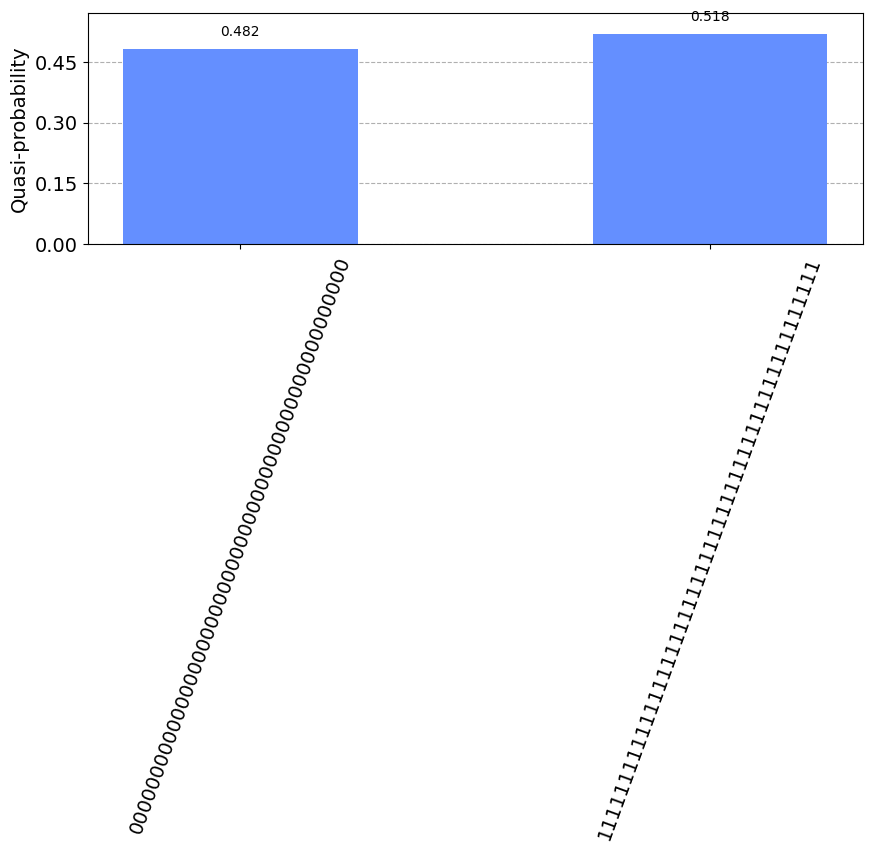

In [12]:
cr = ClassicalRegister(50,'c')
# Add the ClassicalRegister to the QuantumCircuit
qc.add_register(cr)

# qr = QuantumRegister(num_qubits, 'q')

qc.measure(selected_nodes,cr)

# Define the backend and the pass manager
aer_sim = AerSimulator(method='matrix_product_state')
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(backend=aer_sim)
result = sampler.run([isa_circuit]).result()

samp_dist = result[0].data.c.get_counts()
plot_distribution(samp_dist, figsize=(10, 3))

Recorded BFS edges: [(25, 24, None), (25, 26, None), (24, 23, None), (24, 34, None), (26, 27, None), (26, 16, None), (23, 22, None), (34, 43, None), (27, 28, None), (16, 8, None), (22, 21, None), (22, 15, None), (43, 42, None), (43, 44, None), (28, 29, None), (28, 35, None), (8, 7, None), (8, 9, None), (21, 20, None), (15, 4, None), (42, 41, None), (44, 45, None), (29, 30, None), (35, 47, None), (7, 6, None), (9, 10, None), (20, 19, None), (20, 33, None), (4, 3, None), (4, 5, None), (41, 53, None), (41, 40, None), (45, 46, None), (45, 54, None), (30, 31, None), (30, 17, None), (47, 48, None), (10, 11, None), (19, 18, None), (33, 39, None), (3, 2, None), (53, 60, None), (54, 64, None), (31, 32, None), (17, 12, None), (48, 49, None), (18, 14, None), (39, 38, None), (2, 1, None)]
Visited nodes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 53, 54, 60, 64, None}

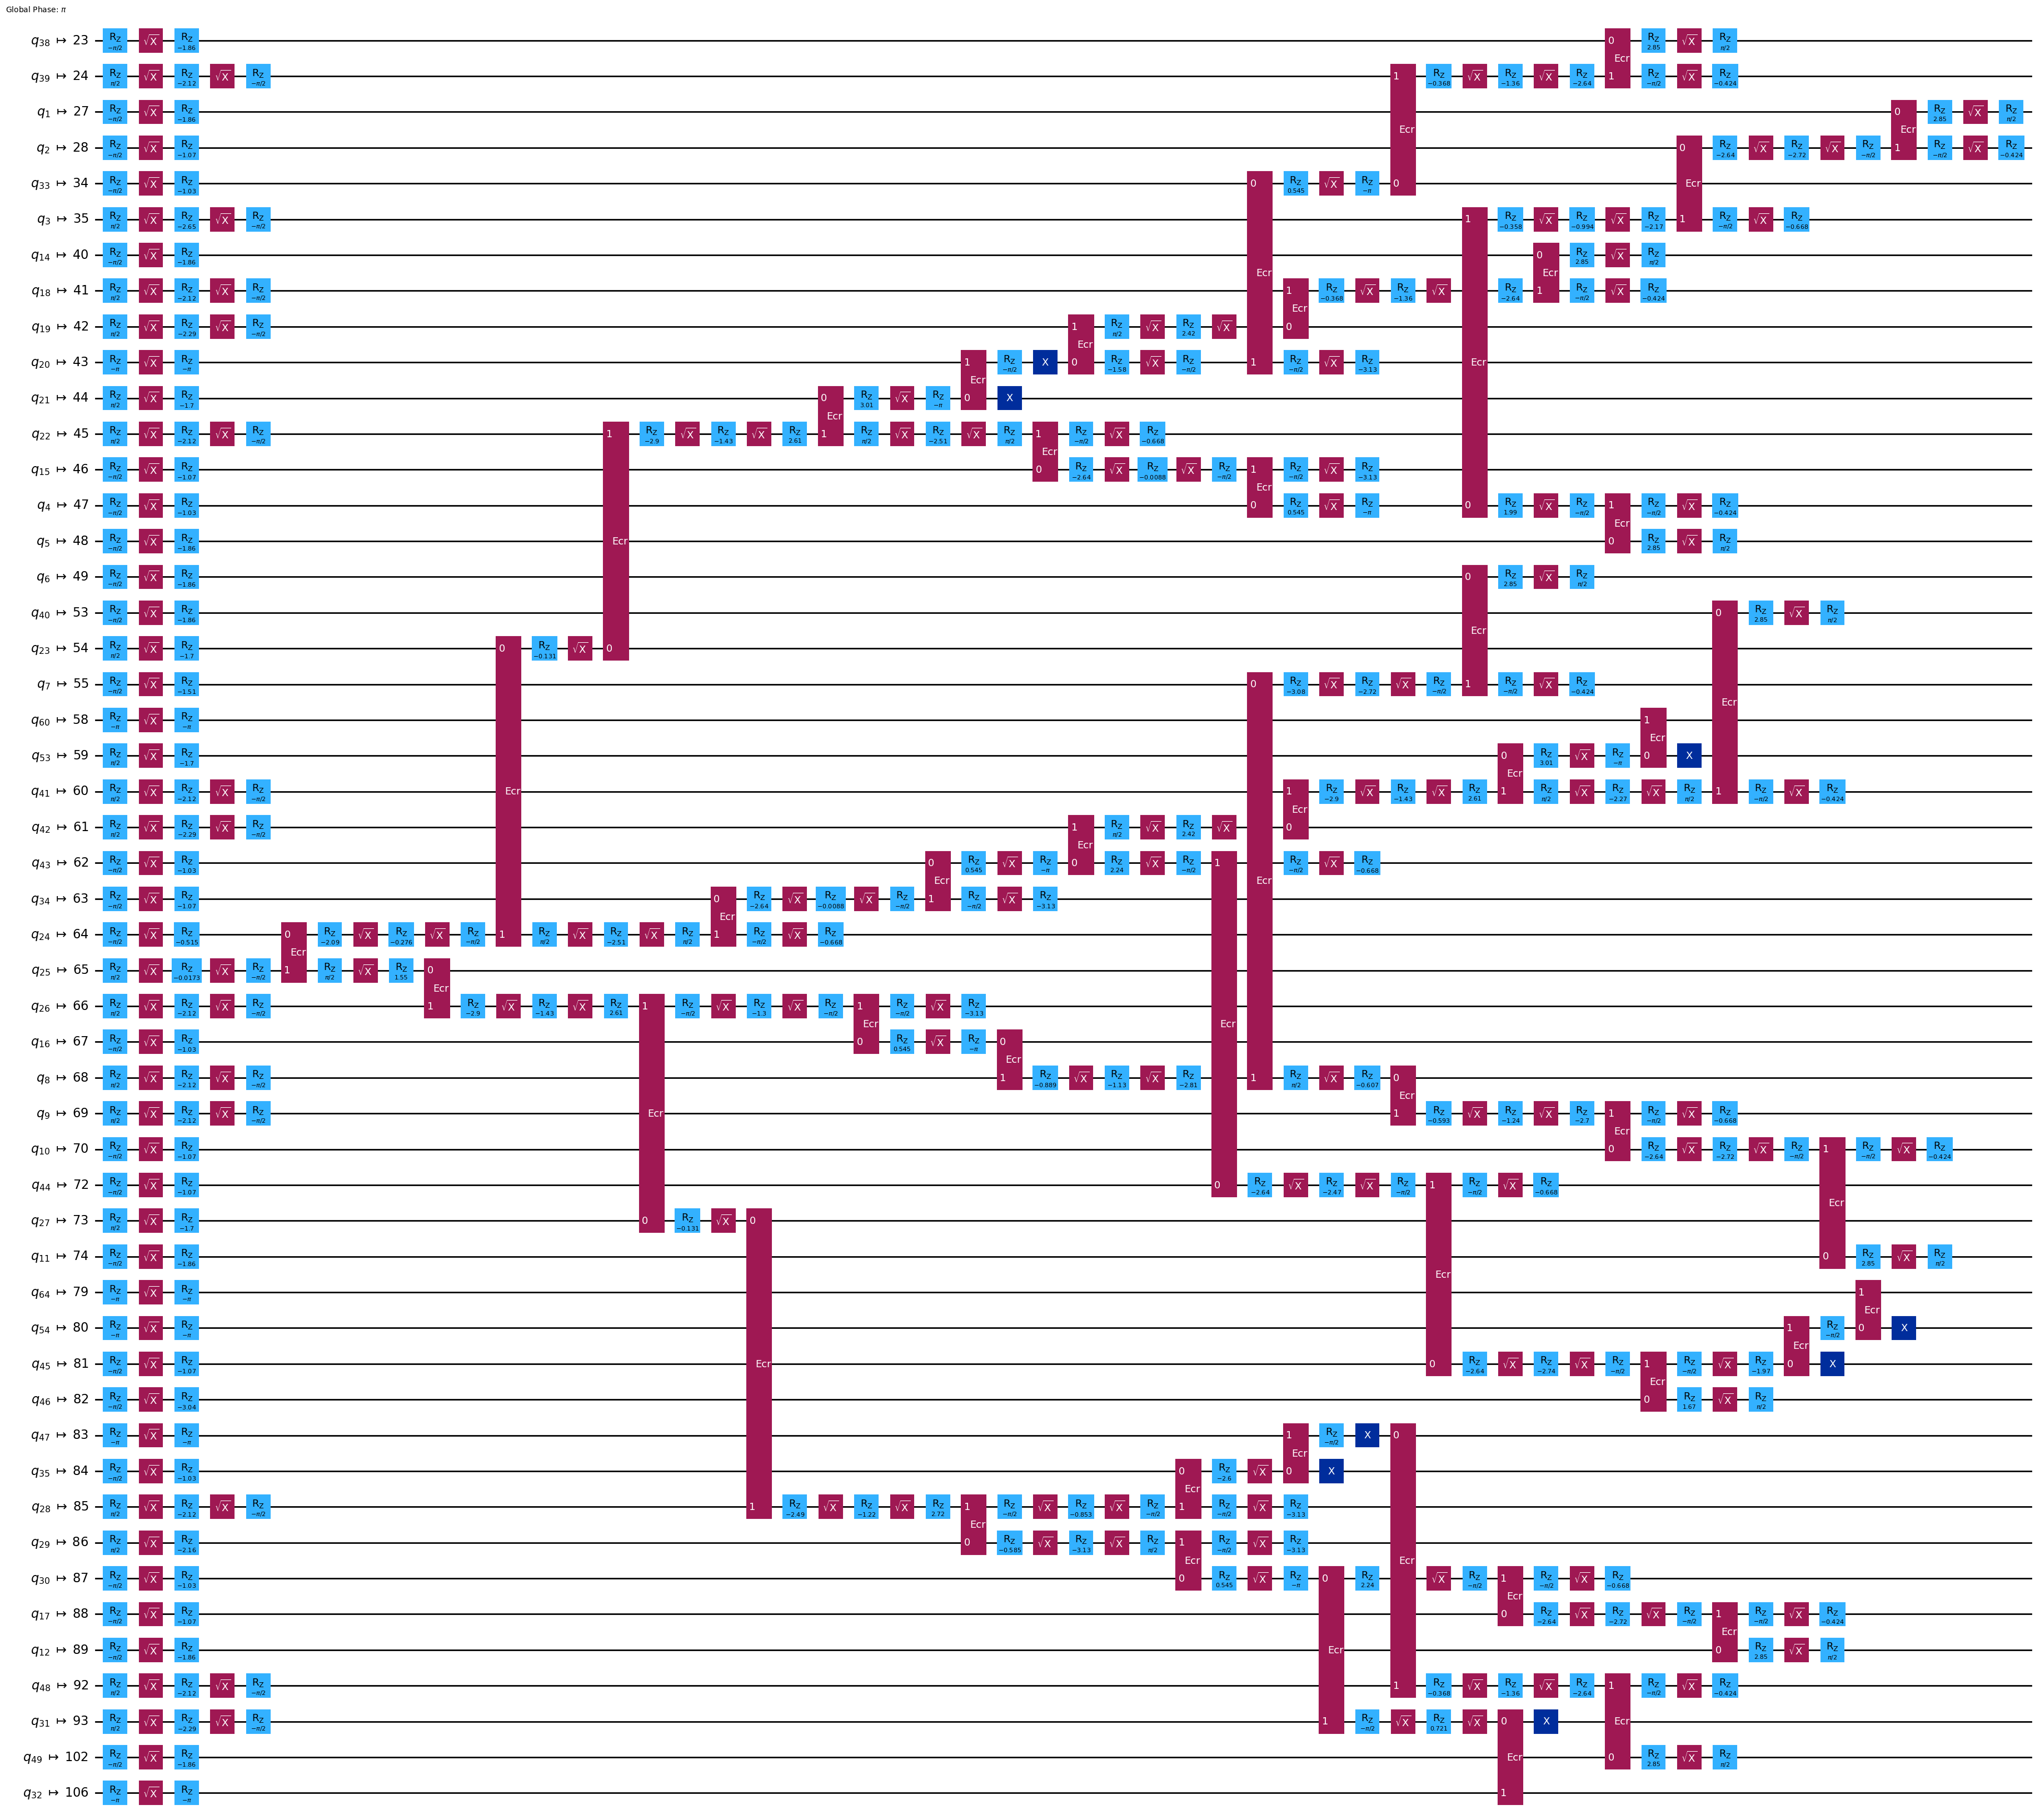

In [14]:
# # Choose a real backend
# service = QiskitRuntimeService()
# backend = service.backend("ibm_kyoto")

# # Define a fake backend with the same properties as the real backend
# fake_backend = AerSimulator.from_backend(backend)

bird_index = 0 #You can check different birds by changing the index
qc, selected_nodes = new_amplitude_embedding(backend=backend, bird_index=bird_index,num_qubits = num_qubits, start_qubit = start_qubit)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

## Step 2: Adapt the `RealAmplitudes` ansatz to the new mapping

The previous ansatz needs to be adapted to the new connectiviy, but without increasing the layers. Check that, when transpiling the ansatz with `pairwise` connectivity together with the `new_amplitude_embedding`, the circuit is more than **100 layers(!)**

In [105]:
from qiskit.circuit import Parameter

In [110]:
def generate_ansatz(num_qubits, opt_params = None, theta = None):
    """Generate a `RealAmplitudes` ansatz where all qubits are entangled with each other 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
    
    Returns:
        qc (QuantumCircuit): Quantum circuit with the generated ansatz
    """
    ### Write your code below here ###
    # qc = QuantumCircuit(num_qubits)
    if opt_params is None:
        opt_params = [Parameter(f'θ_{i}') for i in range(num_qubits)]
    if theta is None:   
        theta = [Parameter(f'θ_{i + num_qubits}') for i in range(num_qubits)]
    # elif len(theta) != num_qubits:
    #     raise ValueError(f"The length of theta list ({len(theta)}) must match the number of qubits ({num_qubits}).")

    for i in range(num_qubits):
        qc.ry(opt_params[i],i)

    entanglement = []
    if num_qubits >= 2:
        for i in range(0, num_qubits - 1, 2):
            entanglement.append([(i, i + 1)])# Layer 1
            qc.cx(i,i+1)
    if num_qubits >= 3:
        for i in range(1, num_qubits - 1, 2):
            entanglement.append([(i, i + 1)])  # Layer 2
            qc.cx(i,i+1)
    if num_qubits >= 4:
        for i in range(0, num_qubits - 2, 3):
            entanglement.append([(i, i + 2) ])  # Layer 3
            qc.cx(i,i+2)

    
    # qc = RealAmplitudes(num_qubits, reps=1, entanglement=entanglement)
    for i in range(num_qubits):
        qc.ry(theta[i],i)





    
    ### Don't change any code past this line ###  
    return qc,entanglement

In [157]:
def generate_ansatz(num_qubits):
    """Generate a `RealAmplitudes` ansatz where all qubits are entangled with each other 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
    
    Returns:
        qc (QuantumCircuit): Quantum circuit with the generated ansatz
    """
    ### Write your code below here ###

    entanglement = []
    if num_qubits >= 2:
        entanglement.append([(i, i + 1) for i in range(0, num_qubits - 1, 2)])  # Layer 1
    if num_qubits >= 3:
        entanglement.append([(i, i + 1) for i in range(1, num_qubits - 1, 2)])  # Layer 2
    if num_qubits >= 4:
        entanglement.append([(i, i + 2) for i in range(0, num_qubits - 2, 3)])  # Layer 3

    entanglement_map = [item for sublist in entanglement for item in sublist]
    
    qc = RealAmplitudes(num_qubits, reps=1, entanglement=entanglement_map)




    
    ### Don't change any code past this line ###  
    return qc,entanglement

In [227]:
num_qubit = 50
index_bird = 0 # You can check different birds by changing the index
new_mapping_qc , selected_nodes = new_amplitude_embedding(backend=backend, bird_index=bird_index,num_qubits = num_qubits, start_qubit = start_qubit)
ansatz, entanglement_map = generate_ansatz(num_qubits)


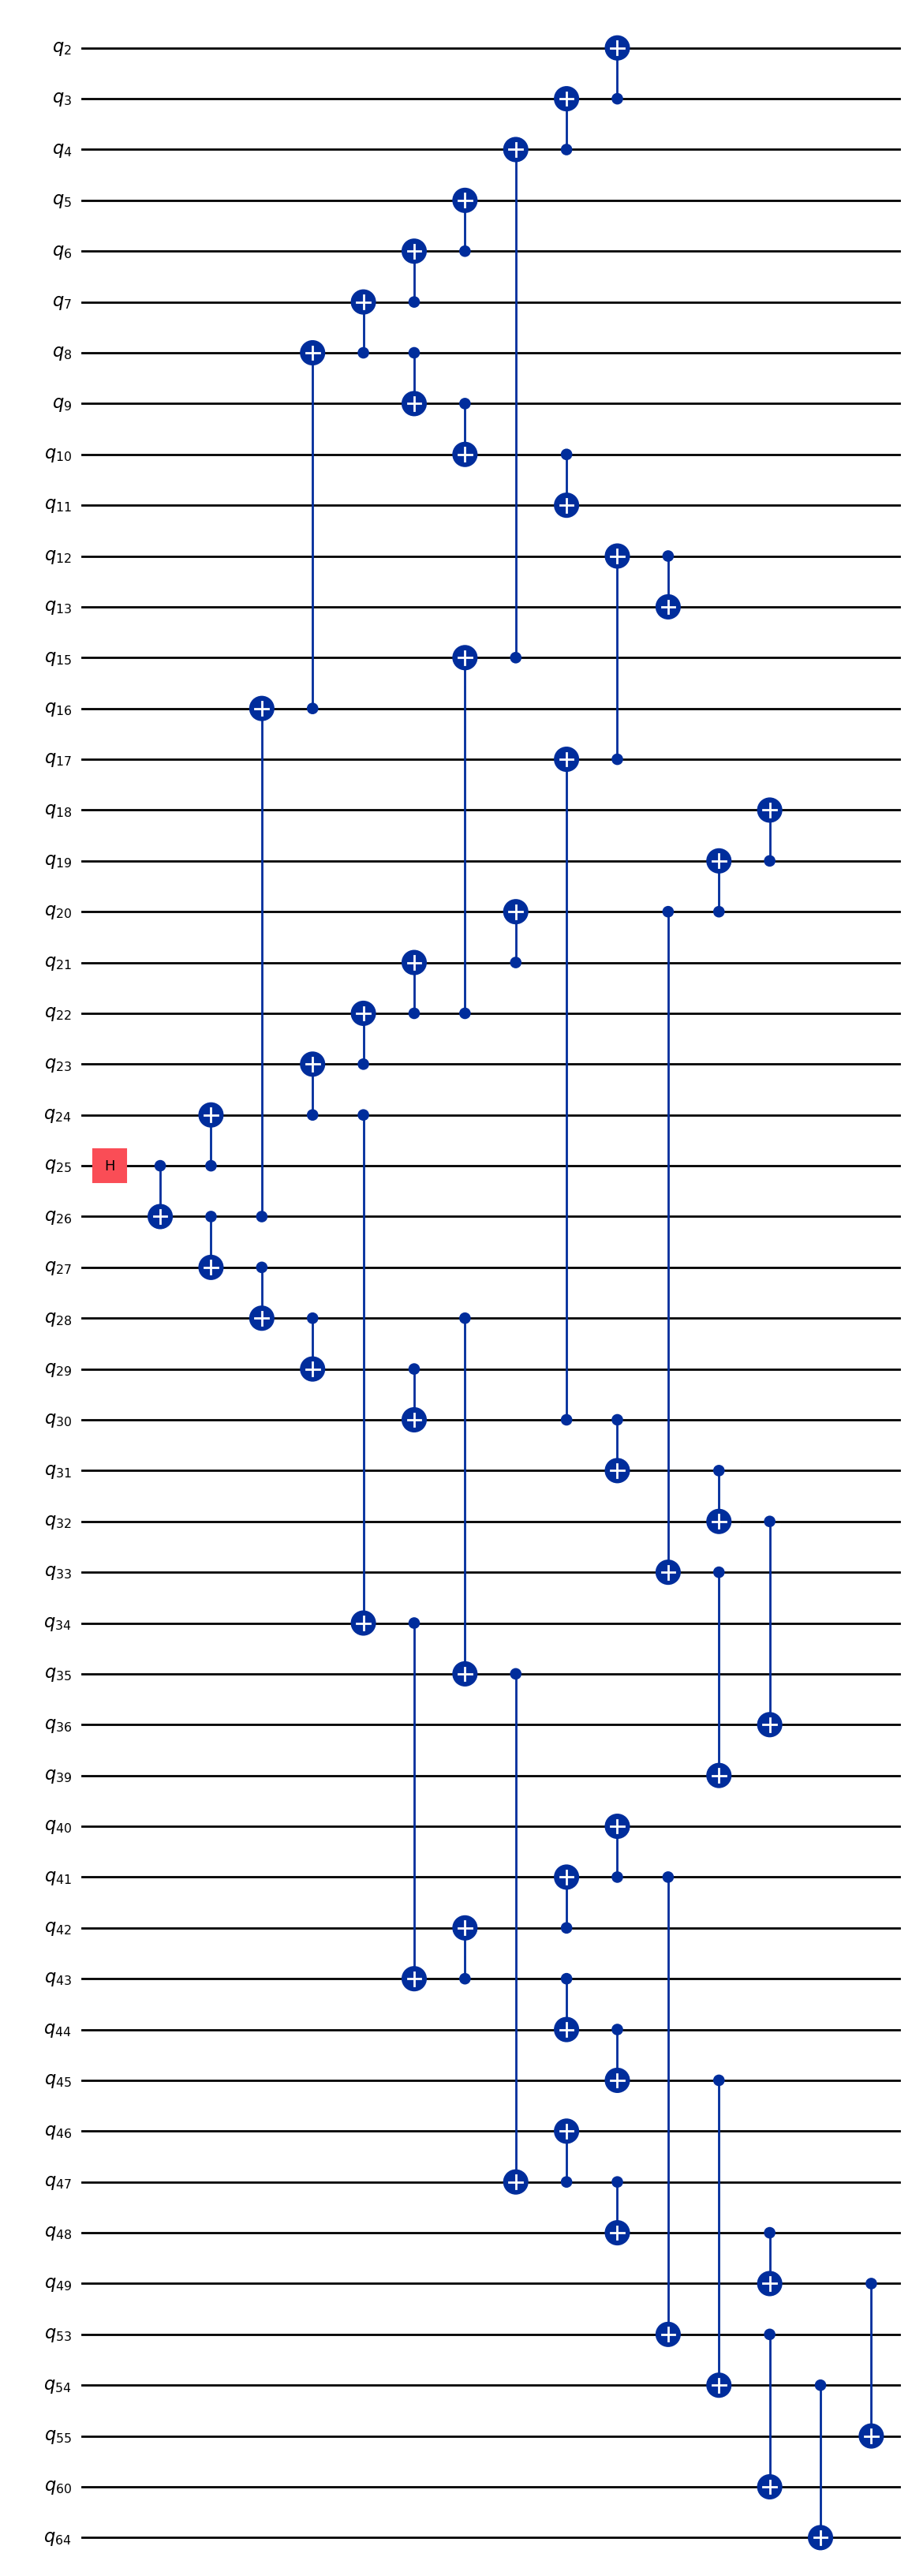

In [228]:
new_mapping_qc.draw('mpl', fold=False, idle_wires=False) 

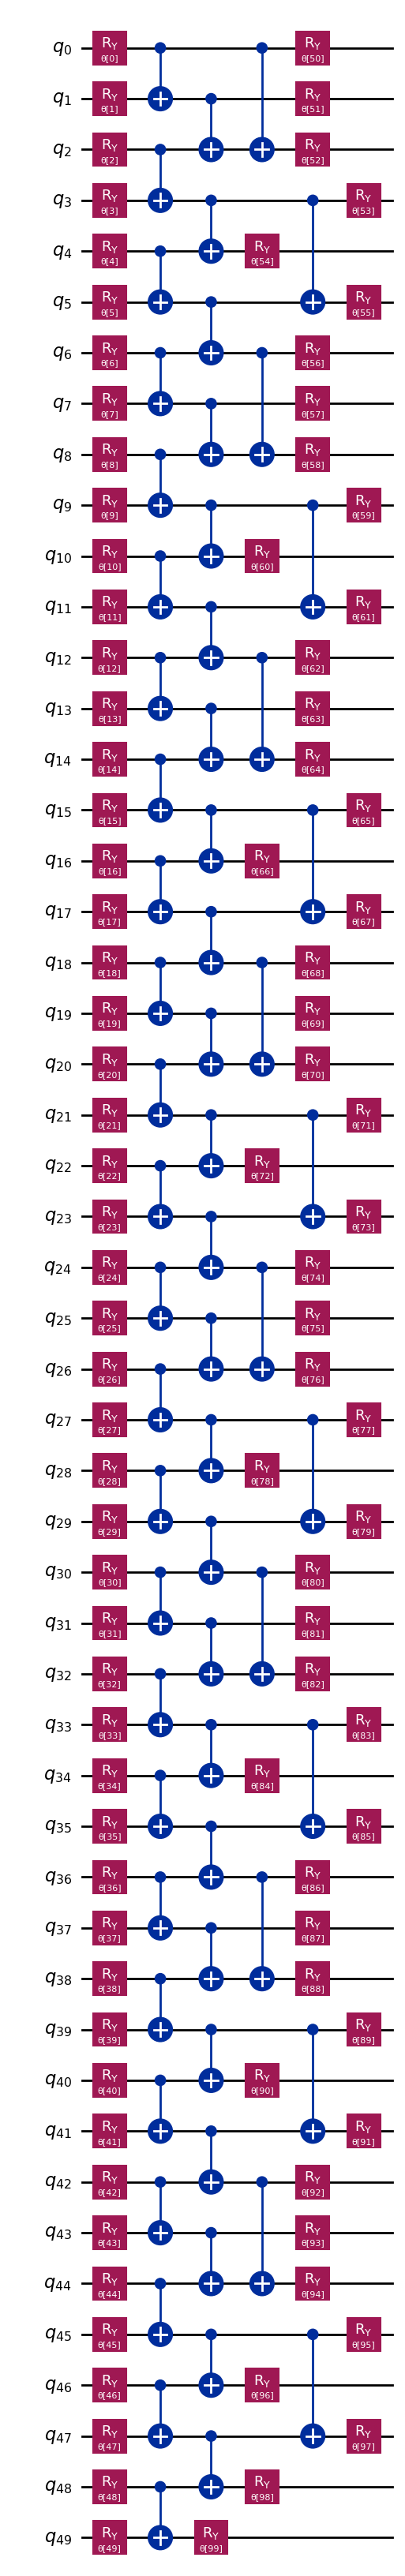

In [229]:
ansatz_de = ansatz.decompose()
ansatz_de.draw('mpl')

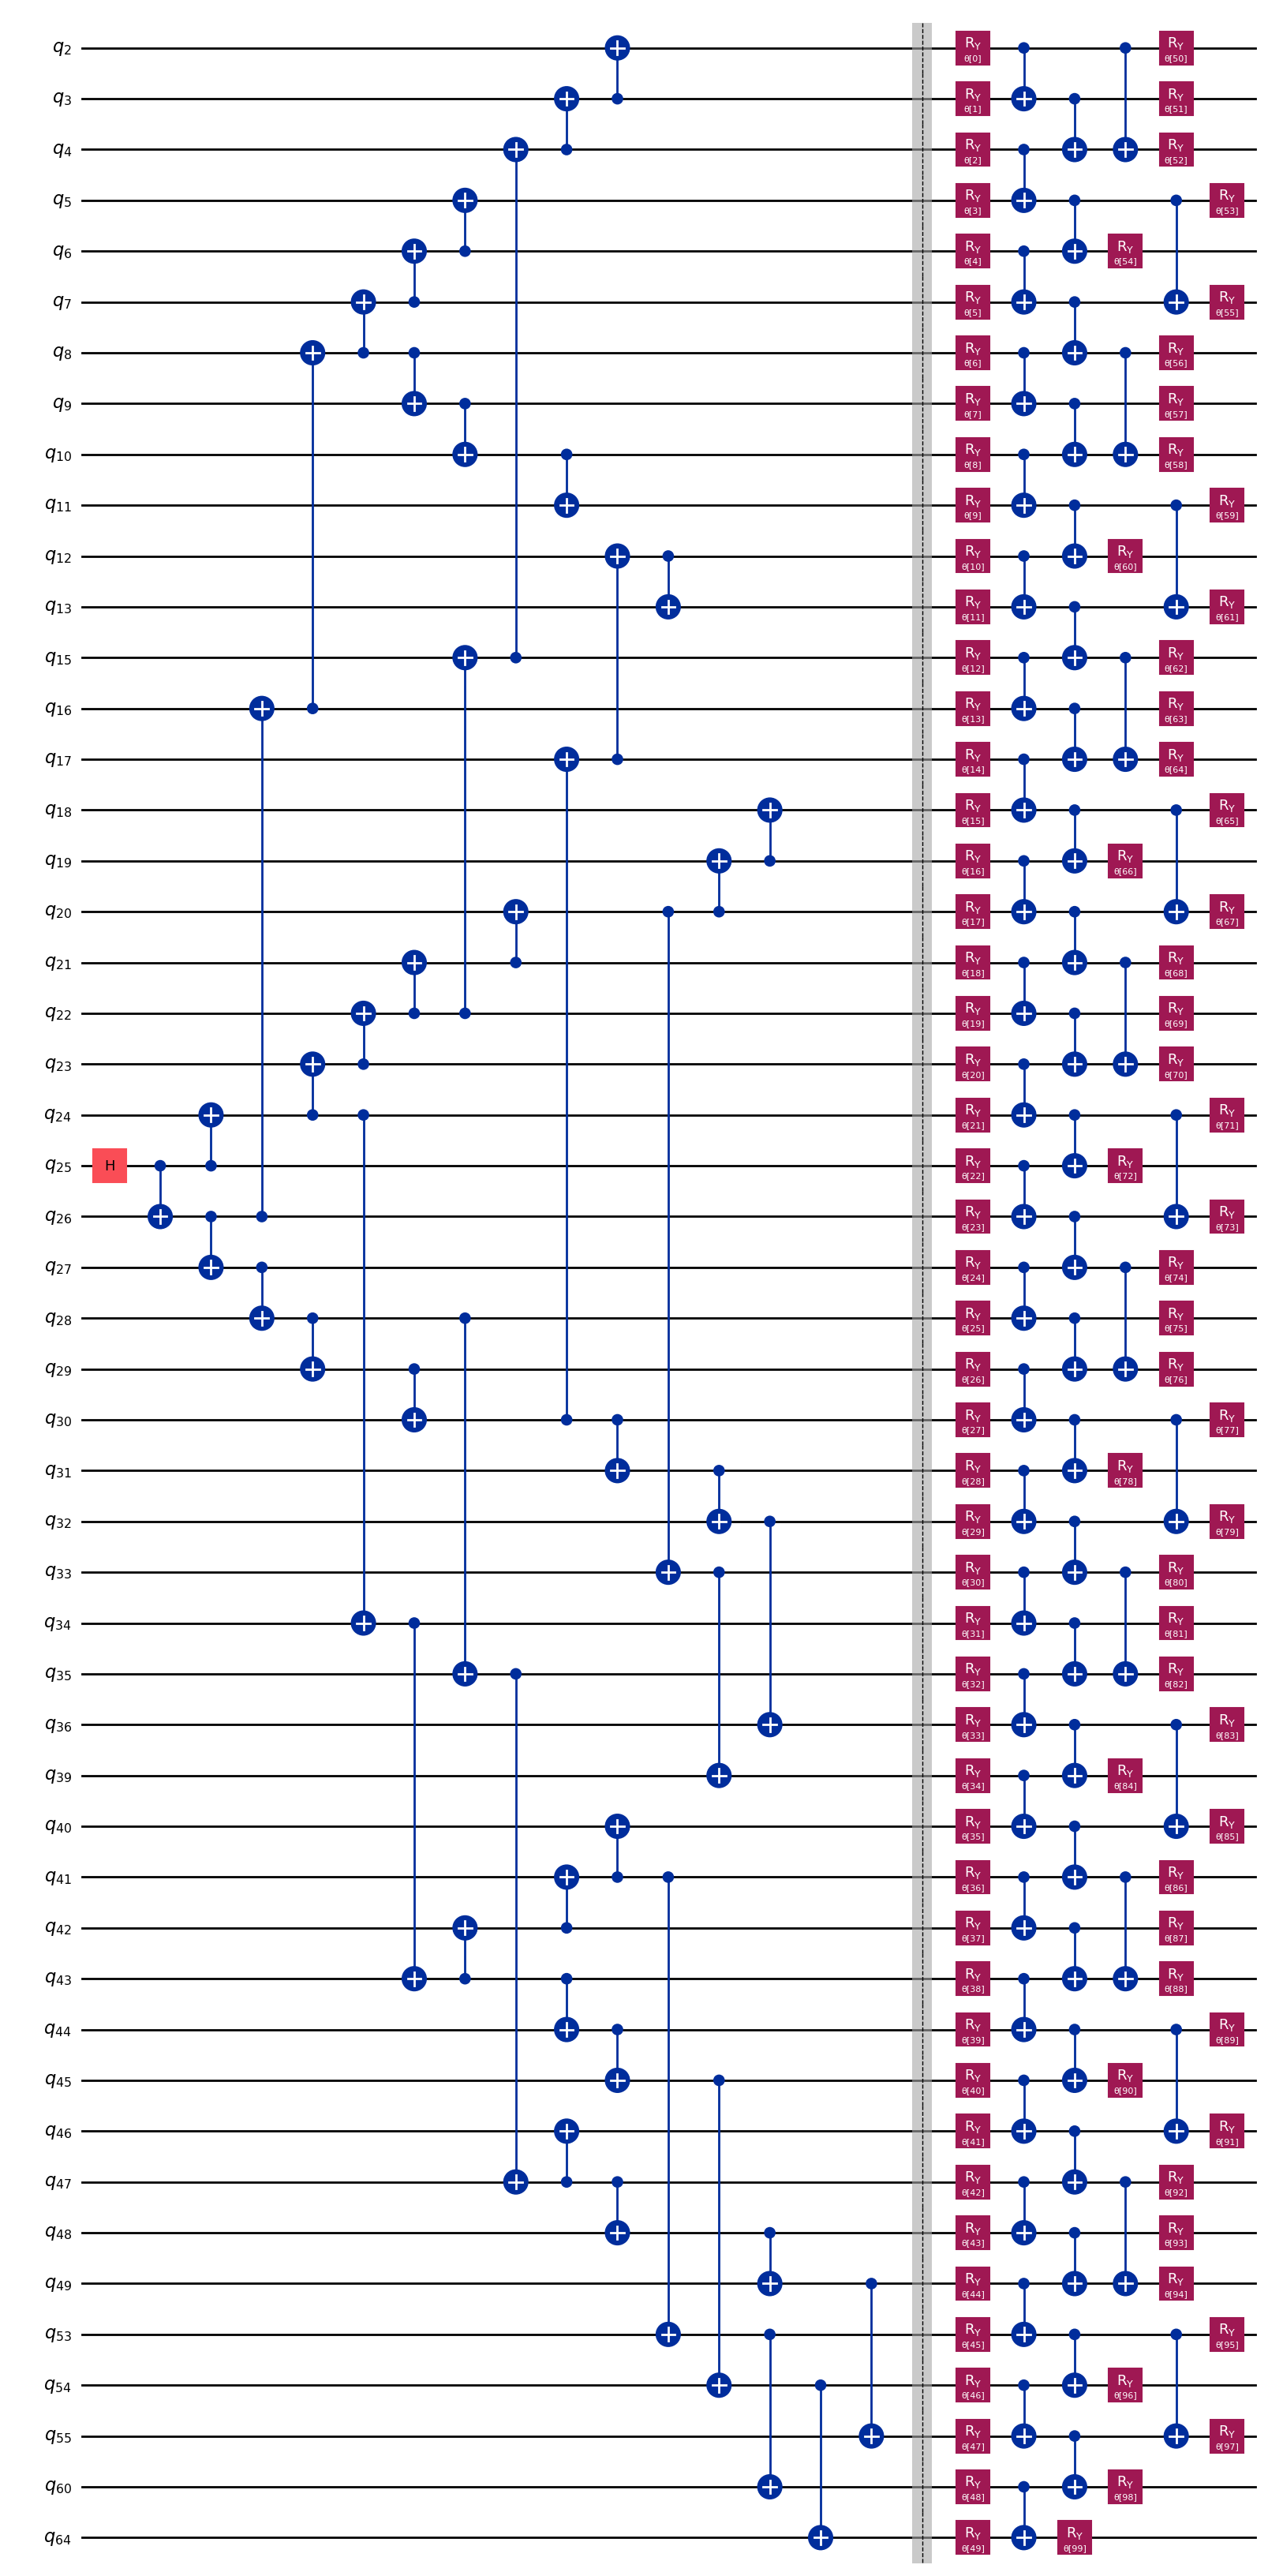

In [230]:
new_mapping_qc.barrier()
new_mapping_qc.compose(ansatz_de, qubits=selected_nodes , inplace='True')

new_mapping_qc.draw('mpl', fold=False, idle_wires=False) 

In [238]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_ansatz = pm.run(ansatz)

print('new ansatz: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))

new ansatz:  25


In [239]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_qc = pm.run(new_mapping_qc)
print('Depth new mapping + new ansatz: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
# transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Depth new mapping + new ansatz:  102


In [240]:
transpiled_qc.draw('mpl', fold=False, idle_wires=False) 

Now we need to generalize the optimal parameters for a 50 qubits VQC.

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

**Task:** The optimal parameters array should have $\pi$ in the first rotation of `RealAmplitudes` for the qubits that are used to entangle other qubits and zero everywhere else. 

*Hint: The easiest way to do this is to generate a `source_list` which contains all qubits which are used as source for any `CX` operation in the ansatz.*

</div>  

In [165]:
# Generate this to match your ansatz

print(entanglement_map)

[[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13), (14, 15), (16, 17), (18, 19), (20, 21), (22, 23), (24, 25), (26, 27), (28, 29), (30, 31), (32, 33), (34, 35), (36, 37), (38, 39), (40, 41), (42, 43), (44, 45), (46, 47), (48, 49)], [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16), (17, 18), (19, 20), (21, 22), (23, 24), (25, 26), (27, 28), (29, 30), (31, 32), (33, 34), (35, 36), (37, 38), (39, 40), (41, 42), (43, 44), (45, 46), (47, 48)], [(0, 2), (3, 5), (6, 8), (9, 11), (12, 14), (15, 17), (18, 20), (21, 23), (24, 26), (27, 29), (30, 32), (33, 35), (36, 38), (39, 41), (42, 44), (45, 47)]]


In [166]:
source_list =sorted(set([tup[0] for tup in entanglement_map[1]]))
# source_list =[tup[0] for tup in entanglement_map]


# # Use a set to collect unique elements
# elements = []

# # Iterate through the nested list and add elements to the set
# for sublist in entanglement_map:
#     for tup in sublist[1]:
#         elements.append(tup[0])

# # Convert the set to a sorted list (if needed)
# unique_elements = set(elements)
# sorted_unique_elements = sorted(unique_elements)

print(source_list)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47]


In [167]:

def generalize_optimal_params(num_qubits, ansatz, source_list):
    """Generate a `list of optimal parameters for N qubits 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        ansatz (QuantumCircuit): Ansatz for our VQC
        source_list (list): List of qubits used as source to entangle other qubits
    
    Returns:
        opt_params (list): List of optimal parameters generated for N qubits
    """
    
    opt_params = np.zeros(ansatz.num_parameters)
    for i in range(ansatz.num_parameters//2):
        if i in source_list:
            opt_params[i] = np.pi

    return opt_params

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

**Task:** Let's recover the `compute_performance` and the `test_shallow_VQC` functions from Lab 4, both to test with the `AerSimulator` and for a `QPU`. Modify the cost function by including a `-1` factor, as the parameters previously calculated are optimized for the inverse of the cost function. 

**Please note:** You need to use the `new_amplitude_embedding` and the `generate_ansatz` functions which you created above

</div>  

In [225]:


def test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend, start_qubit):
    """Tests the shallow VQC on a QPU
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        list_labels (list): List of labels
        obs: (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Options for Estimator primitive
        backend (Backend): Real backend from IBM Quantum to run the job
    
    Returns:
        job_id (str): Job ID for Quantum job
    """
    estimator = Estimator(backend=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    ### Write your code below here ###
    pubs = []
    for bird_index, label in enumerate(list_labels):
        # qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc, selected_qubits = new_amplitude_embedding( backend, bird_index, num_qubits, start_qubit)
        ansatz,entanglement_map = generate_ansatz(num_qubits)
        # Compose initial state + ansatz
        # shallow_classifier = qc.compose(ansatz, qubits=selected_nodes , inplace='True')
        # qc.compose(ansatz, qubits=selected_nodes , inplace='True')
        # shallow_classifier = qc.compose(ansatz)
        shallow_classifier = qc
        # Transpile classifier
        transpiled_shallow_classifier = pm.run(shallow_classifier)
        # Transpile classifier
        # transpiled_shallow_classifier = pm.run(qc)
        # Transpile observable
        transpiled_shallow_obs = obs.apply_layout(layout=transpiled_shallow_classifier.layout)
        # Run estimator
        opt_params = []
        pub = (transpiled_shallow_classifier, transpiled_shallow_obs, opt_params)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")

     
    
    ### Don't change any code past this line ###                         
                        
    return job_id



In [200]:

def retrieve_job(job_id):
    """Retrieve test results from job id
    Parameters: 
        job_id (str): Job ID
    Returns:
        results_test (list): List of test results
        errors_test (list): List of test errors
    """
    
    job = service.job(job_id)
    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(abs(result.data.evs)-1)) #COST FUNCTION HAS A -1 NOW!!!
        errors_test.append(abs(result.data.stds))
        
    return results_test, errors_test


In [236]:

def test_shallow_VQC_CPU(num_qubits, list_labels, obs, opt_params, options, backend, start_qubit,estimator):
    """Tests the shallow VQC on a QPU
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        list_labels (list): List of labels
        obs: (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Options for Estimator primitive
        backend (Backend): AerSimulator backend to run the job
    
    Returns:
        results_test (list): List of test results
    """
    Q_backend = service.backend("ibm_osaka")
    results_test = []
    ### Write your code below here ###
    for bird_index, label in enumerate(list_labels):
        # qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc, selected_qubits = new_amplitude_embedding( Q_backend, bird_index, num_qubits, start_qubit)
        ansatz,entanglement_map = generate_ansatz(num_qubits)
        # Compose initial state + ansatz
        # shallow_classifier = qc
        shallow_classifier = qc.compose(ansatz,qubits=selected_nodes , inplace='True')
        # Transpile classifier
        transpiled_shallow_classifier = pm.run(qc)
        # transpiled_shallow_classifier = pm.run(shallow_classifier)
        # Transpile observable
        transpiled_shallow_obs = obs.apply_layout(layout=transpiled_shallow_classifier.layout)
        # Run estimator
        # opt_params=[]
        pub = (transpiled_shallow_classifier, transpiled_shallow_obs, opt_params)
        

        job = estimator.run([pub])
        


     ### Don't change any code past this line ### 
        result = job.result()[0].data.evs
        results_test.append(abs(abs(result)-1)) # COST FUNCTION NOW HAS A -1!!!  
                                           
    return results_test


In [241]:

def compute_performance(result_list, list_labels):
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        performance (float): Performance of the classifier
    """
    ### Write your code below here ###
    performance = 0
    cost = 0
    for result, lable in zip(result_list, list_labels):
        cost += (np.abs(result - lable)) / 2 ** 5
    
    performance = 100 - 100 * cost

        
    ### Don't change any code past this line ###                                    
    return performance

Now we are ready to check if everything works using MPS (tensor networks). This is just to check the circuit and not to benchmark it, hence we are not transpiling the circuit nor applying any noise models.

<div class="alert alert-block alert-danger">

**Please note:** Please do not transpile before checking your result in the code below. This is just a check and not a benchmark.

</div>

In [245]:
new_mapping_qc, selected_nodes = new_amplitude_embedding(backend=backend, bird_index=bird_index,num_qubits = num_qubits, start_qubit = start_qubit)

Performance for resilience 0: 99.76043701171875


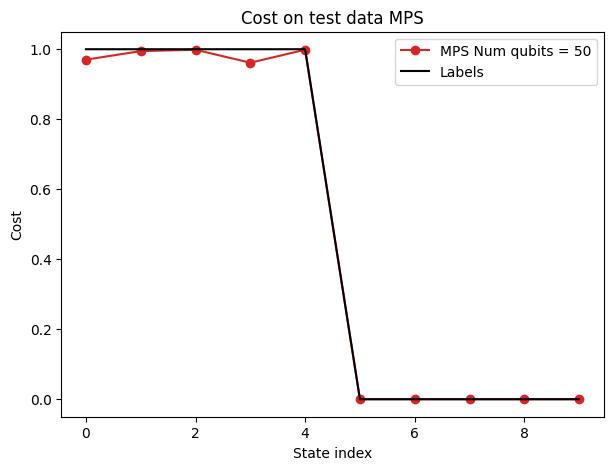

In [246]:

num_qubits = 50
total_qubits = 127

aer_sim = AerSimulator(method='matrix_product_state')
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(new_mapping_qc)
transpiled_ansatz = pm.run(ansatz)

# list_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
list_labels = np.append(np.ones(5), np.zeros(5))
# obs = SparsePauliOp("Z"*total_qubits)
# Define the observable (Pauli Z on each selected qubit)
pauli_string = ''.join(['Z' if i in selected_nodes else 'I' for i in range(total_qubits)])
pauli_string = pauli_string[::-1]
obs = SparsePauliOp.from_list([(pauli_string, 1.0)])

# coefficients = [1 if p == 'Z' else 0 for p in pauli_string]

# qubits = isa_circuit.qubits
# observable = sum(Operator('Z' * (len(qubits) - i) + 'I' * i) for i, q in enumerate(qubits) if qubits[i] in selected_nodes)

    # qr = QuantumRegister(127, 'q')
    # # Create a list of qubits from the QuantumRegister using the qubit indices
    # qubits = [qr[i] for i in qubit_indices]


opt_params = generalize_optimal_params(num_qubits, transpiled_ansatz, source_list)
options = EstimatorOptions()
estimator = Estimator(backend = aer_sim)

results_test_aer_sim = test_shallow_VQC_CPU(num_qubits, list_labels, obs, opt_params, options, backend, start_qubit, estimator)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data MPS')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
print(f"Performance for resilience 0: {compute_performance(results_test_aer_sim, list_labels)}")
ax.plot(results_test_aer_sim, 'o-', color='tab:red', label='MPS Num qubits = ' + str(num_qubits))
ax.plot(list_labels, 'k-', label='Labels')
ax.legend()

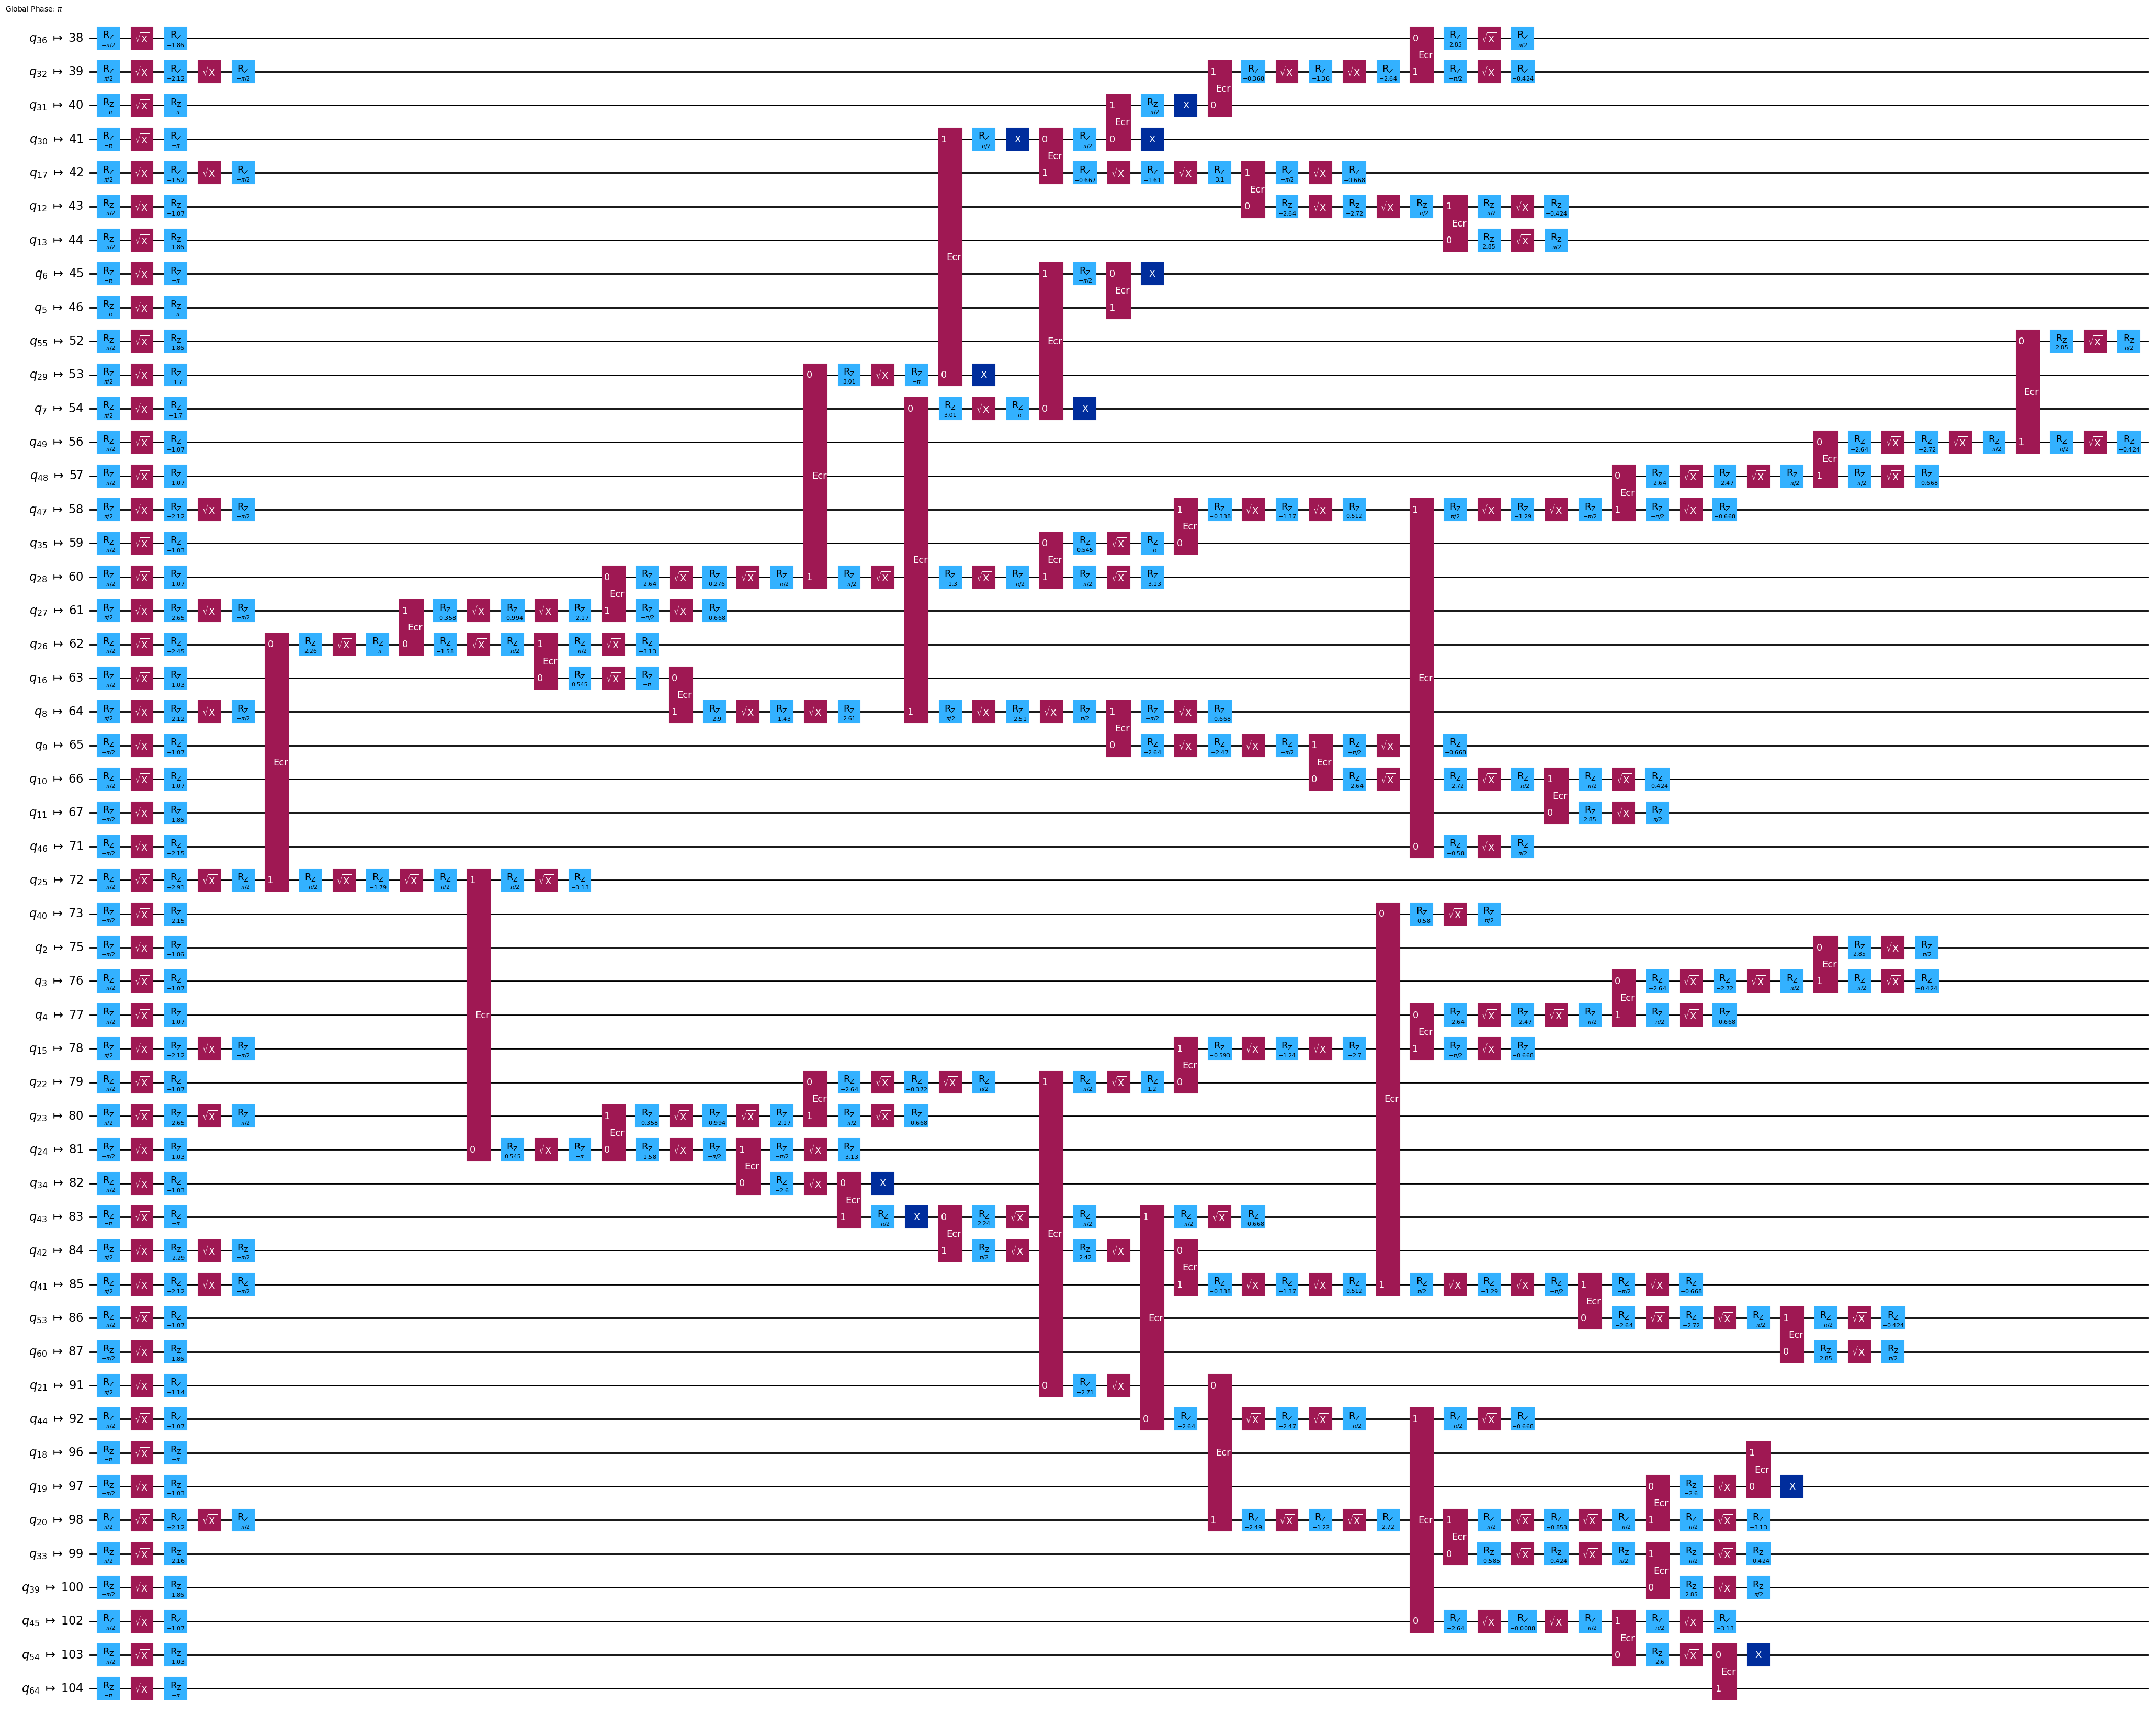

In [247]:
isa_circuit.draw('mpl', fold=False, idle_wires=False) 


In [250]:
print('Depth new mapping : ', isa_circuit.depth(lambda x: len(x.qubits) == 2))

Depth new mapping :  10


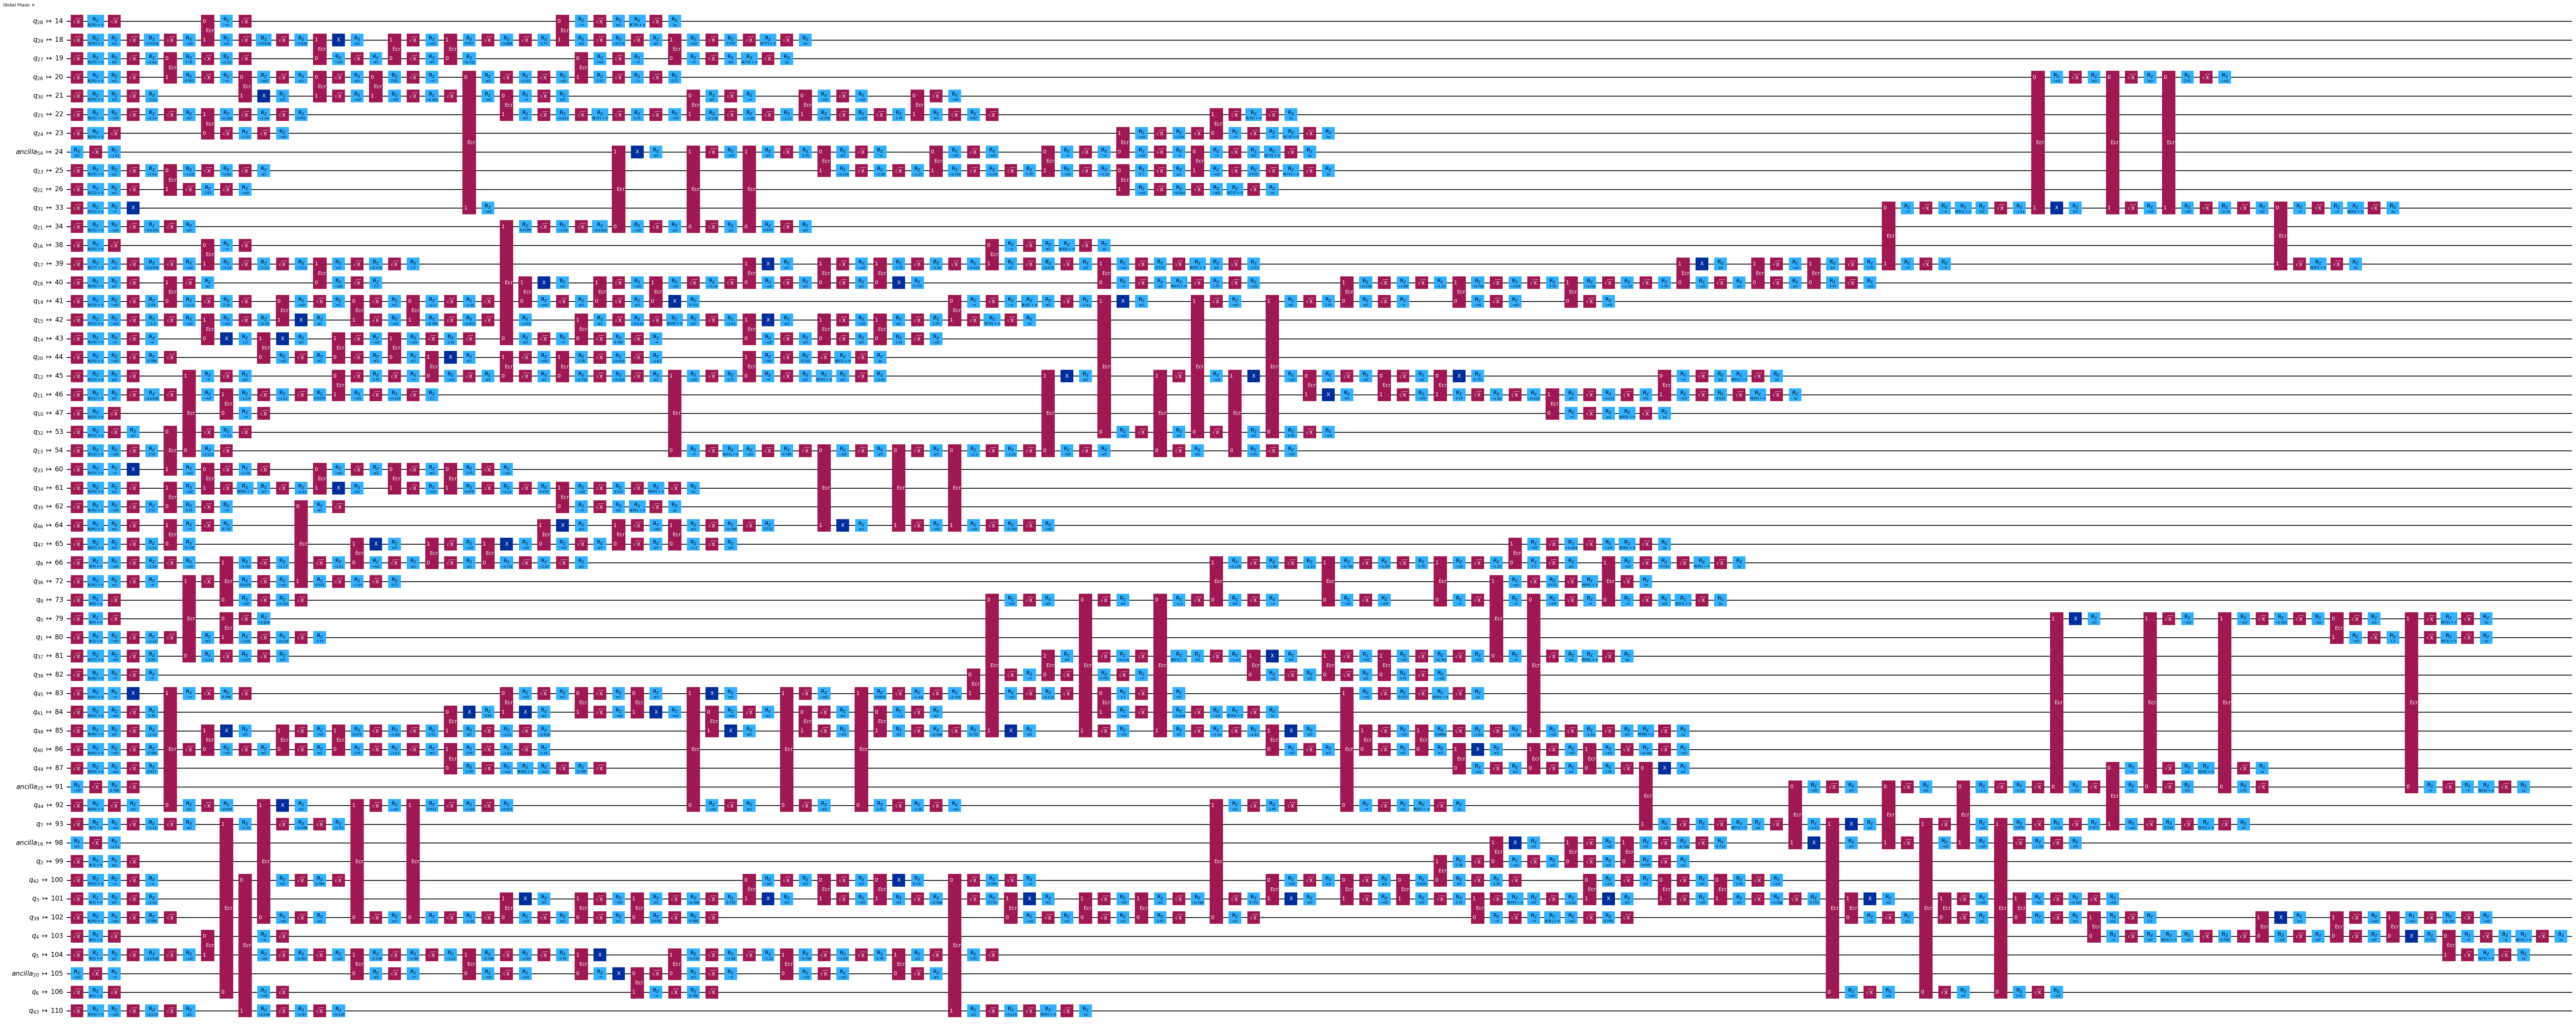

In [251]:
transpiled_ansatz.draw('mpl', fold=False, idle_wires=False) 

In [253]:
print('Depth new mapping : ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))

Depth new mapping :  28


In [254]:
isa_circuit.compose(transpiled_ansatz, inplace='True')

In [255]:
isa_circuit.draw('mpl', fold=False, idle_wires=False) 

In [256]:
print('Depth new mapping + new ansatz : ', isa_circuit.depth(lambda x: len(x.qubits) == 2))

Depth new mapping + new ansatz :  36


## Final step: Testing a 50 qubit VQC on a quantum device (!)

At this point, you should be all set to run your VQC on a real device!  Lets start by choosing our device. For this part of the Lab, we recommend choosing an IBM Quantum backend that you have access to, since we will use these simulations as a guide to run the code on the real backend later on. Take into account that the properties of the devices can change a lot from one to another, so testing the VQC might not work so well for certain devices. We have used [ibm_sherbrooke](https://quantum.ibm.com/services/resources?system=ibm_sherbrooke). 

You can find the list of systems you have access to on [the Systems tab](https://quantum.ibm.com/services/resources?resourceType=current-instance&order=queue%20ASC&view=table) on IBM Quantum platform or run the following code:

```python
    from qiskit_ibm_runtime import QiskitRuntimeService

    service = QiskitRuntimeService()
    # list all available systems
    service.backends()
    # get the least busy system
    backend = service.least_busy()
```


<div class="alert alert-block alert-danger">

**Please note:** Please perform the checks above before running it on the real device to ensure you make the best use of your QPU time.

</div>

In [202]:
service = QiskitRuntimeService()
backend = service.backend("ibm_kyoto")

Let us specify options for our real system run. You can review the explainations on `options` from [Lab 4](https://github.com/qiskit-community/ibm-quantum-challenge-2024/blob/main/content/lab_bonus/lab-bonus.ipynb#Zero-Noise-Extrapolation-(ZNE))

More detais about how to configure `options` for error mitigation with for Qiskit runtime can be found in [this tutorial](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive) as well as in [the documentation](https://docs.quantum.ibm.com/run/configure-error-mitigation).




In [187]:
### Save API Token, if needed

%set_env QXToken=ad20ff9823f36a54582853d35ab4356fcc2e6dcd02c520165cbb2e9a3d67b25ead0d79fc977eba2fb94b69c9de31479f75e07598af639edc6cb0041b9517bc1c

# Make sure there is no space between the equal sign
# and the beginning of your token

env: QXToken=ad20ff9823f36a54582853d35ab4356fcc2e6dcd02c520165cbb2e9a3d67b25ead0d79fc977eba2fb94b69c9de31479f75e07598af639edc6cb0041b9517bc1c


<div class="alert alert-block alert-danger">

**Please note:** For `10000` shots the estimated runtime is around 4 min and for `5000` it will be around 2 minutes. Please be mindful of the QPU time limitation you have on your account
</div>

In [210]:
# RUN JOBS
num_qubits = 50
total_qubits = 127
# list_labels = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
list_labels = np.append(np.ones(5), np.zeros(5))

# Define the observable (Pauli Z on each selected qubit)
pauli_string = ''.join(['Z' if i in selected_nodes else 'I' for i in range(total_qubits)])
pauli_string = pauli_string[::-1]
obs = SparsePauliOp.from_list([(pauli_string, 1.0)])

estimator = Estimator(backend = backend)

# obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, transpiled_ansatz, source_list)

for resilience in [0,2]:

    DD = True
    options = EstimatorOptions(default_shots = 10_000, 
                            optimization_level=0, 
                            resilience_level=resilience)  
    options.dynamical_decoupling.enable = DD
    options.dynamical_decoupling.sequence_type = 'XpXm'

    # OPTIONAL
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = (1, 1.2, 1.5)
    options.resilience.zne.extrapolator = ('exponential', 'linear', 'polynomial_degree_2') #order matters

    job_id = test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend, start_qubit)

Job ID: csp36tvvnxy0008deyag
Status: QUEUED
Job ID: csp378nvwqp0008b4700
Status: QUEUED


##### You can use the cell below to plot your results

Performance for no DD + no TREX: 100.000
Performance for DD + TREX: 100.000


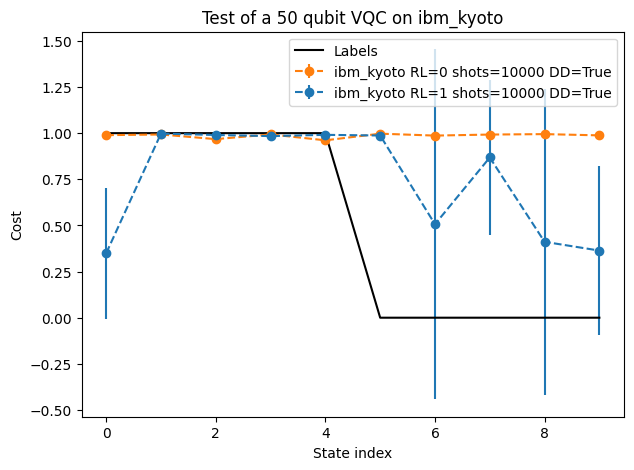

In [197]:
##Forgot to flip the obs
results_test_0_DD, errors_test_0_DD = retrieve_job('csp2chap1vzg008add1g') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csp2cyvvnxy0008dewt0') 

backend = service.backend("ibm_kyoto")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

Performance for no DD + no TREX: 100.000
Performance for DD + TREX: 100.000


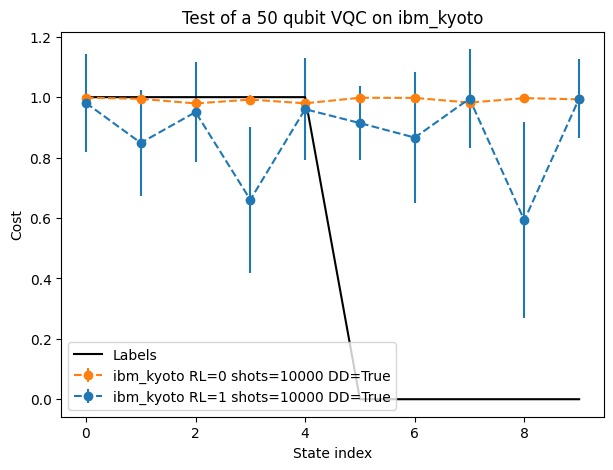

In [198]:
##obs fliped
results_test_0_DD, errors_test_0_DD = retrieve_job('csp2f1cvwqp0008b4550') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csp2fh6vnxy0008dewz0') 

backend = service.backend("ibm_kyoto")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

Performance for no DD + no TREX: 100.000
Performance for DD + TREX: 100.000


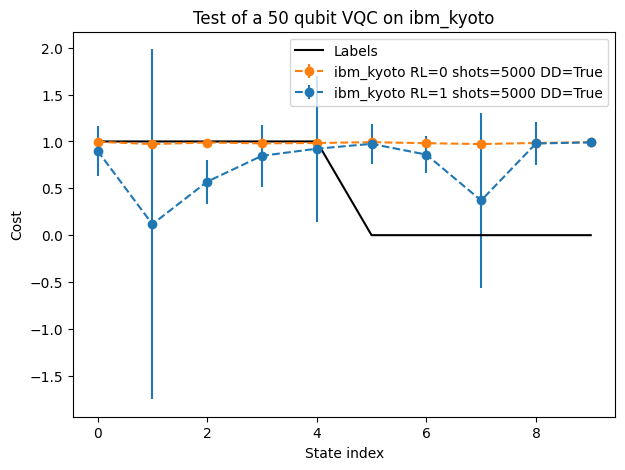

In [209]:
##obs fliped, remove inplace = True between qc and ansatz
results_test_0_DD, errors_test_0_DD = retrieve_job('csp3124ea560008fhg0g') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csp31g6p1vzg008ade6g') 

backend = service.backend("ibm_kyoto")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

In [ ]:
##obs fliped, remove inplace = True between qc and ansatz/
#Shots increase to 10000, ZEN applied
results_test_0_DD, errors_test_0_DD = retrieve_job('csp36tvvnxy0008deyag') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csp378nvwqp0008b4700') 

backend = service.backend("ibm_kyoto")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=2 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

##### You can use the cell below to plot your results

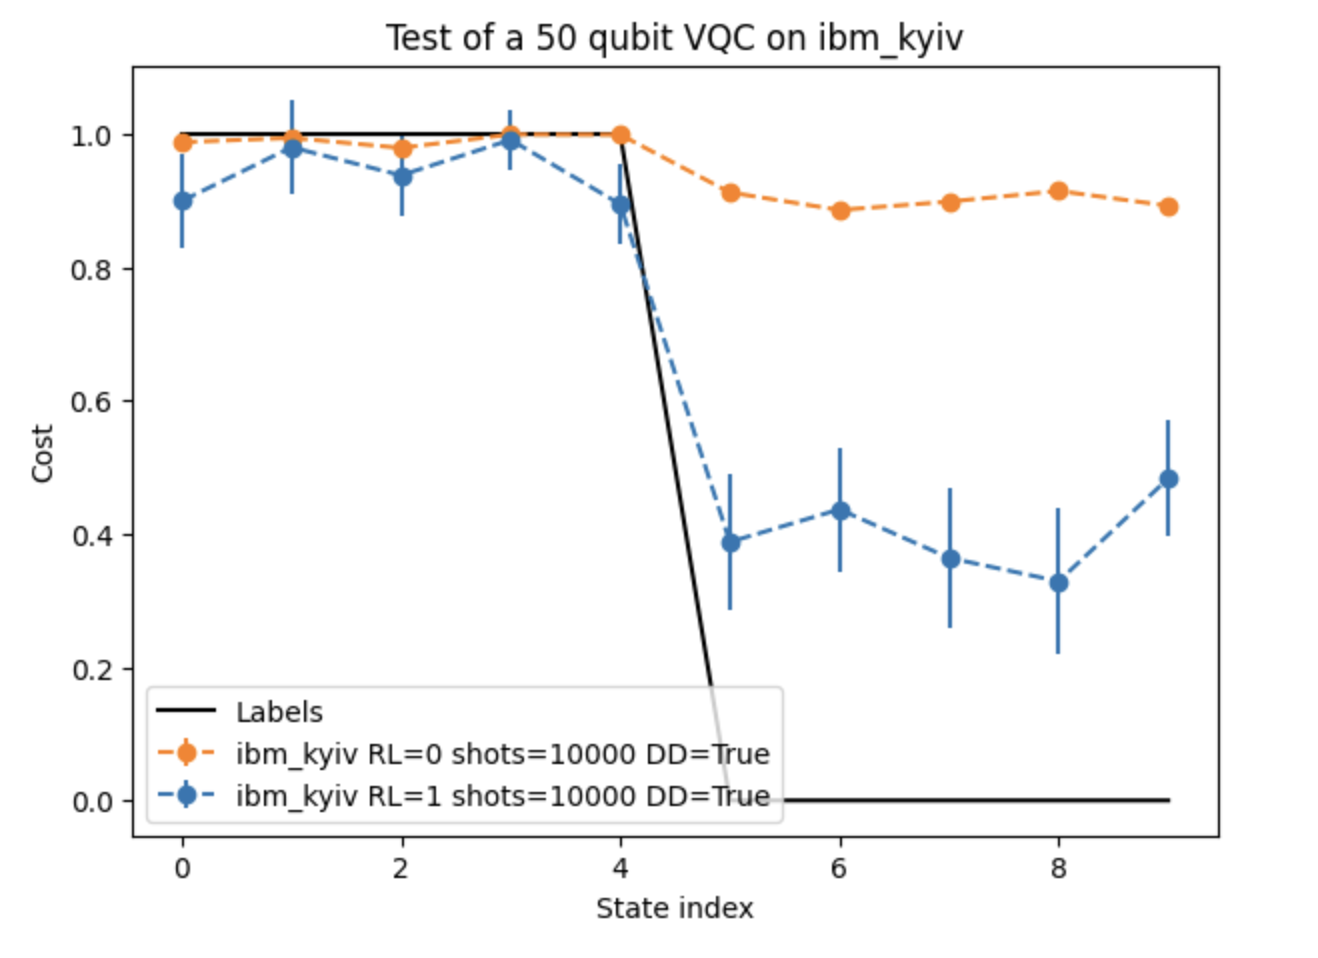

In [208]:
service = QiskitRuntimeService()
backend = service.backend("ibm_cleveland")



# RUN JOBS
num_qubits = 50
total_qubits = 127
start_qubit = 25
list_labels = np.append(np.ones(5), np.zeros(5))

# Define the observable (Pauli Z on each selected qubit)
pauli_string = ''.join(['Z' if i in selected_nodes else 'I' for i in range(total_qubits)])
pauli_string = pauli_string[::-1]
obs = SparsePauliOp.from_list([(pauli_string, 1.0)])




# obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, transpiled_ansatz, source_list)

for resilience in [0,1,2]:

    DD = True
    options = EstimatorOptions(default_shots = 5_000, 
                            optimization_level=0, 
                            resilience_level=resilience)  
    options.dynamical_decoupling.enable = DD
    options.dynamical_decoupling.sequence_type = 'XpXm'

    # OPTIONAL
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = (1, 1.2, 1.5)
    options.resilience.zne.extrapolator = ('exponential', 'linear', 'polynomial_degree_2') #order matters

    job_id = test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend, start_qubit)


Job ID: csp34k2vwqp0008b46n0
Status: QUEUED
Job ID: csp350wea560008fhgfg
Status: QUEUED
Job ID: csp35dxp1vzg008adem0
Status: QUEUED


Performance for no DD + no TREX: 100.000
Performance for DD + TREX: 100.000


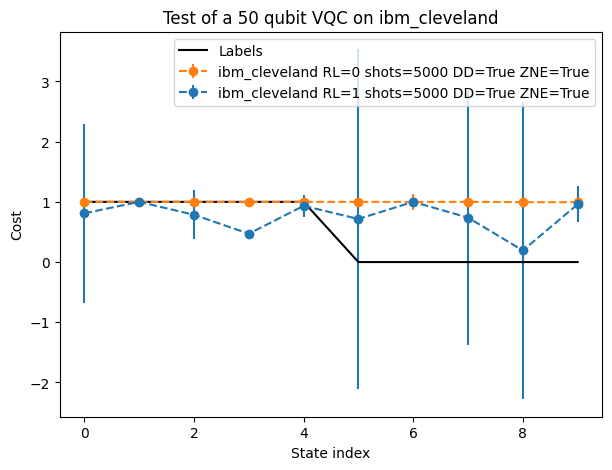

In [207]:
##### You can use the cell below to plot your results
results_test_0_DD, errors_test_0_DD = retrieve_job('csp2j2gp1vzg008addb0') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csp2jeh0c2pg008c3bf0') 
# results_test_2_DD, errors_test_2_DD = retrieve_job('csp2jtv0c2pg008c3bfg') 

backend = service.backend("ibm_cleveland")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
# print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_2_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}' )
# ax.errorbar(range(10), results_test_2_DD, fmt='--o',  yerr=errors_test_2_DD, color='tab:green', label=f'{backend.name} RL=2 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

Performance for no DD + no TREX: 100.000
Performance for DD + TREX: 100.000


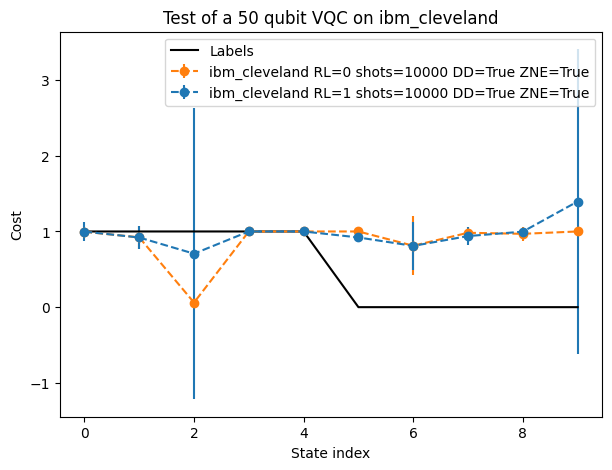

In [211]:
##### You can use the cell below to plot your results
results_test_0_DD, errors_test_0_DD = retrieve_job('csp34k2vwqp0008b46n0') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csp350wea560008fhgfg') 
# results_test_2_DD, errors_test_2_DD = retrieve_job('csp35dxp1vzg008adem0') 

backend = service.backend("ibm_cleveland")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
# print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_2_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}' )
# ax.errorbar(range(10), results_test_2_DD, fmt='--o',  yerr=errors_test_2_DD, color='tab:green', label=f'{backend.name} RL=2 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

In [258]:
service = QiskitRuntimeService()
backend = service.backend("ibm_cleveland")



# RUN JOBS
num_qubits = 50
total_qubits = 127
start_qubit = 25
list_labels = np.append(np.ones(5), np.zeros(5))

# Define the observable (Pauli Z on each selected qubit)
pauli_string = ''.join(['Z' if i in selected_nodes else 'I' for i in range(total_qubits)])
pauli_string = pauli_string[::-1]
obs = SparsePauliOp.from_list([(pauli_string, 1.0)])




# obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, transpiled_ansatz, source_list)

for resilience in [0,1,2]:

    DD = True
    options = EstimatorOptions(default_shots = 5_000, 
                            optimization_level=0, 
                            resilience_level=resilience)  
    options.dynamical_decoupling.enable = DD
    options.dynamical_decoupling.sequence_type = 'XpXm'

    # OPTIONAL
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = (1, 1.2, 1.5)
    options.resilience.zne.extrapolator = ('exponential', 'linear', 'polynomial_degree_2') #order matters

    # job_id = test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend, start_qubit)


Performance for no DD + no TREX: 85.891
Performance for DD + TREX: 84.266
Performance for DD + TREX + ZNE: 79.134


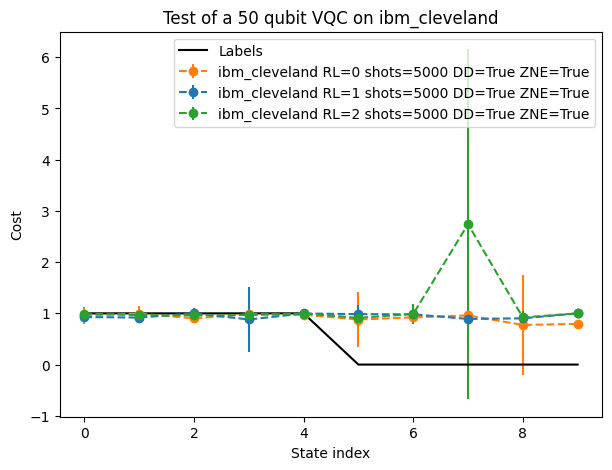

In [261]:

##### You can use the cell below to plot your results
results_test_0_DD, errors_test_0_DD = retrieve_job('csp9t1rvwqp0008b4mkg') 
results_test_1_DD, errors_test_1_DD = retrieve_job('csp9t2rea560008fhya0') 
results_test_2_DD, errors_test_2_DD = retrieve_job('csp9t400c2pg008c3vqg') 

backend = service.backend("ibm_cleveland")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
print(f"Performance for DD + TREX + ZNE: {compute_performance(results_test_2_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}' )
ax.errorbar(range(10), results_test_2_DD, fmt='--o',  yerr=errors_test_2_DD, color='tab:green', label=f'{backend.name} RL=2 shots={options.default_shots} DD={options.dynamical_decoupling.enable} ZNE={options.resilience.zne_mitigation}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 